In [9]:
from datetime import date
from qutip import *
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

In [10]:
def plot_wigner(rho, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax=plt.subplots(1,1,figsize=(8,8))
    if isket(rho):
        rho=ket2dm(rho)
    xvec=linspace(-7.5, 7.5, 200)
    W=wigner(rho,xvec,xvec)
    wlim=abs(W).max()
    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('Greys'))
    ax.set_xlabel(r'x1', fontsize=16)
    ax.set_ylabel(r'x2', fontsize=16)
    return fig, ax

In [14]:
class system:
    def __init__(self, catsize, start, stop, num):
        self.catsize=catsize
        self.start=start
        self.stop=stop
        self.num=num
        self.tlist=linspace(self.start, self.stop, self.num)
        self.N=15
        self.x=[]
        self.y=[]
        self.z=[]
        self.fid=[]
        self.t=[]
        self.a=destroy(self.N)
        self.ad=self.a.dag()
        self.H0=self.ad*self.ad*self.a*self.a
        self.Hdet=self.ad*self.a
        self.Hx=self.ad*self.ad+self.a*self.a
        self.Hy=self.ad*self.ad-self.a*self.a
        self.zero=basis(self.N, 0)
        self.one=basis(self.N, 1)
        self.N_plus=(1/(sqrt(2*(1+(exp((-2)*self.catsize))))))
        self.zero=coherent(self.N, 0)
        self.expectedcat=self.N_plus*(coherent(self.N, sqrt(self.catsize))+coherent(self.N, -sqrt(self.catsize)))
    def Epy(self, t,args):
        Ep= self.P0*self.chi*(1-exp((-(t)**4)/(self.tau**4)))
        alpha_0=sqrt(Ep/self.chi)
        alpha_prime=sqrt(0.5*(1/sqrt(self.catsize*(1-exp((-(t)**4)/(self.tau**4)))))*((-1)*self.catsize*exp((-(t)**4)/(self.tau**4)))*((-4)*(t**3)/(self.tau**4)))
        N_m=1/(sqrt(2*(1-exp((-2)*(self.catsize)))))
        return (1j*alpha_prime)/((1+2*alpha_0)*(N_m))
    def init_fidelity_exp(self, spec, kstart, kstop, knum, vstart, vstop, vnum): 
        kerr=linspace(kstart, kstop, knum)
        tau_speed=linspace(vstart,vstop, vnum) # adiabatic cond tau>>1/(Delta_gap=4Kn) =>min v=0.1!(JW setting)
        #power=linspace(self.catsize-1, 4*(self.catsize-1.5), 5 )
        power=linspace(0.5*self.catsize, self.catsize, 5 )
        #power=[4,5]
        for chi in kerr:
            for v in tau_speed:
                for p in power :
                    def Epx_k_v(t, args):
                        return (2*pi)*chi*p*(1-exp((-(t)**4)/((v/(2*pi)*chi)**4)))
                    result=mesolve([(-1)*(2*pi)*chi*self.H0,[self.Hx, Epx_k_v]],self.zero, self.tlist, [], [])
                    # def Epy(t,args):
                    #     Ep= (2*pi)*chi*p*(1-exp((-(t)**4)/((v/(2*pi*chi))**4)))
                    #     alpha_0=sqrt(Ep/(2*pi)*chi)
                    #     alpha_prime=sqrt(0.5*(1/sqrt(self.catsize*(1-exp((-(t)**4)/((v/(2*pi*chi))**4)))))*((-1)*self.catsize*exp((-(t)**4)/((v/(2*pi*chi))**4)))*((-4)*(t**3)/((v/(2*pi*chi))**4)))
                    #     N_m=1/(sqrt(2*(1-exp((-2)*(self.catsize)))))
                    #     return (1j*alpha_prime)/((1+2*alpha_0)*(N_m))
                    # result=mesolve([(-1)*(2*pi)*chi*self.H0,[self.Hx, Epx_k_v],[self.Hy,Epy] ],self.zero, self.tlist, [], [])         
                    # def detuning(t, args):
                    #     return (-1.7)*(2*pi*chi)*(1-(t/(v/(2*pi*chi))))
                    f=[]
                    for i in range(len(self.tlist)):
                        f.append(fidelity(self.expectedcat, result.states[i]))
                    maxfid=max(f)
                    if maxfid<0.9 or maxfid>1.00: #fidelity can be over 100 (ex 124) for extraordinarily distorted cat. need to be excluded!!
                        pass
                    if 0.9<=maxfid<=1.00:
                        self.x.append(chi)
                        self.y.append(v)
                        self.z.append(p)
                        self.fid.append(round(maxfid*100,2))
                        self.t.append(round(((self.stop-self.start)/self.num)*(f.index(maxfid)+1),2))
                    f.clear()
        fig=plt.figure(figsize=(10,10))
        ax=fig.add_subplot(111,projection='3d')
        scatter=ax.scatter(self.x,self.y,self.z, c=self.fid, marker='o', s=15, cmap='Greys',vmin=90,vmax=100)
        ax.set_title(f"catsize={self.catsize}",fontsize=20)
        ax.set_xlabel('kerr(MHz)')
        ax.set_ylabel('ramp speed')
        ax.set_zlabel('MaxDrvAmp')
        plt.colorbar(scatter,shrink=0.6, location='left').set_label('Fidelity(%)')
        name=f"{spec},n={self.catsize},k=({kstart},{kstop},{knum}),v=({vstart},{vstop},{vnum})"
        file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/data/fidelity/230219/{name}.png"
        plt.savefig(file_name, format='png', dpi=100, bbox_inches='tight')
        plt.show()
    def generate(self, spec, chi, v, p,speed):
        n=len(self.tlist)
        chi2pi=chi*2*pi
        def E_px(t, args):
            return p*chi2pi*(1-exp((-(t)**4)/((v/chi2pi)**4)))
        H=[(-1)*chi2pi*self.H0,[self.Hx, E_px]]
        result=mesolve(H, self.zero, self.tlist, [], [])        
        # fidelity, time
        f=[]
        for i in range(n):
            f.append(fidelity(self.expectedcat, result.states[i]))
        maxfid=max(f)
        maxfid_idx=f.index(maxfid)
        time_taken=((self.stop-self.start)/self.num)*(maxfid_idx+1)
        print(maxfid)
        print(time_taken)
        # animation
        fig, ax= plt.subplots(1,1,figsize=(8,8))
        def update(frame):
            plot_wigner(result.states[frame*speed], fig=fig, ax=ax)
        ani=animation.FuncAnimation(fig, update, frames=int(n/speed))
        FFwriter=animation.FFMpegWriter()
        name=f"n={self.catsize},{spec},({chi},{v},{p}),Ft=({round(maxfid*100,2)},{round(time_taken,3)}us),t=({self.start},{self.stop},{self.num}).mp4"
        file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/animation/230219/{name}.mp4"
        ani.save(file_name, writer=FFwriter)
        plt.close()
        return plot_wigner(result.states[maxfid_idx])
    
        

### init_fidelity only detuning not working -> abandon det, only optimizing drive pump

In [12]:
ref4=system(catsize=4, start=0, stop=2,num=2000)

In [24]:
ref2=system(catsize=2, start=0, stop=2,num=2000)

In [5]:
ref6=system(catsize=6, start=0, stop=2,num=2000)

In [6]:
ref8=system(catsize=8, start=0, stop=2,num=2000)

In [15]:
ref1=system(catsize=10, start=0, stop=2,num=2000)

0.9997564218950233
1.3800000000000001


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

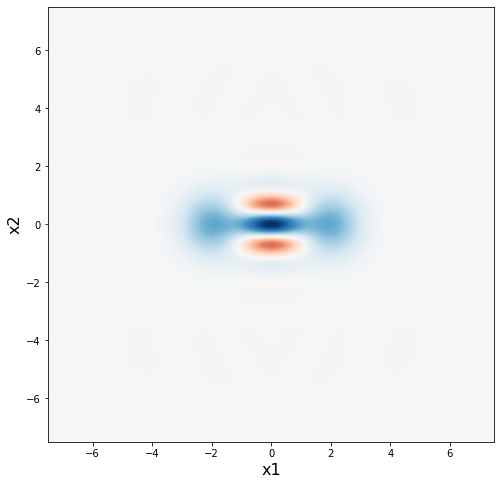

In [49]:
ref2.generate('rdbu',chi=0.75, v=5, p=2, speed=20)

0.998500370278381
1.3800000000000001


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

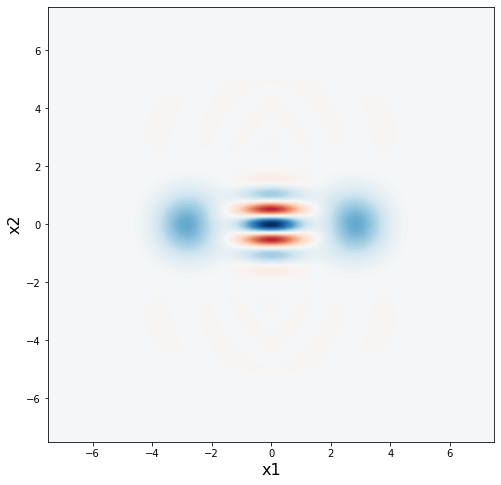

In [50]:
ref4.generate('rdbu',chi=0.75, v=5, p=4, speed=20)

1.0039639756514565
1.348


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

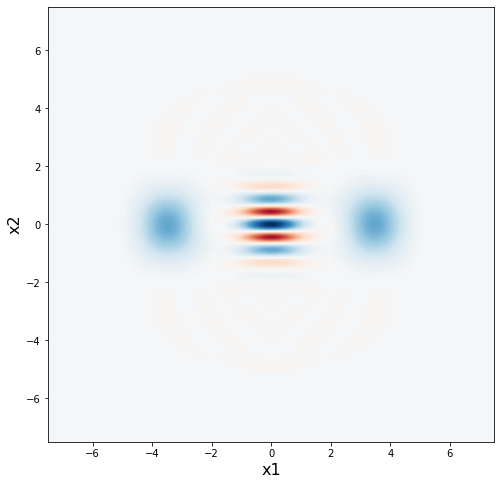

In [51]:
ref6.generate('rdbu',chi=0.75, v=5, p=6, speed=20)

1.0096370843584301
1.96


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

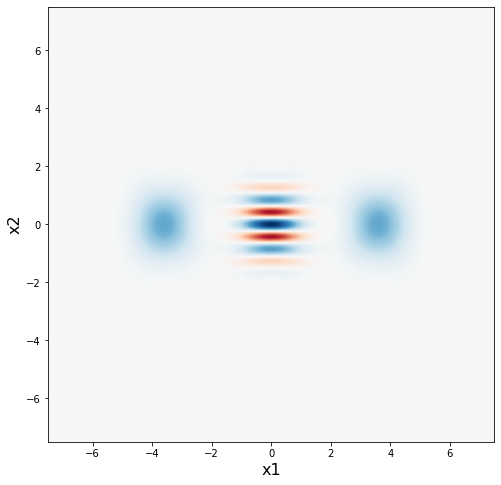

In [57]:
ref8.generate('rdbu',chi=0.75, v=5, p=6, speed=20)

0.991792271291233
1.96


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

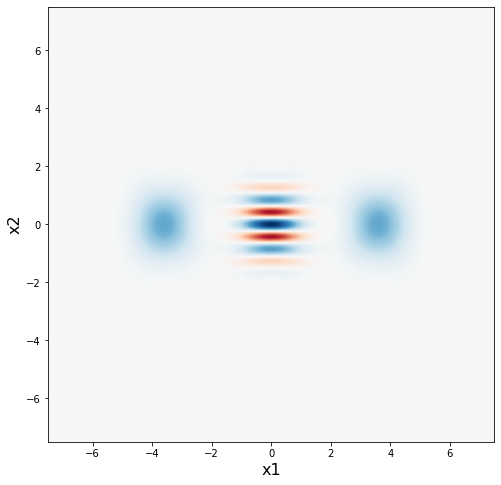

In [55]:
ref1.generate('rdbu',chi=0.75, v=5, p=6, speed=20)

0.9997564218950233
1.3800000000000001


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

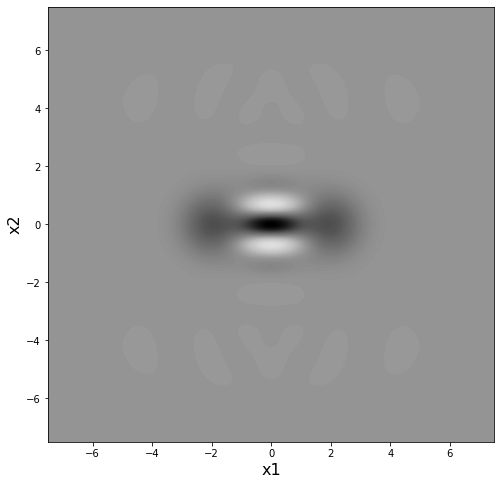

In [ ]:
ref.generate('grey',chi=0.75, v=5, p=4, speed=20)

0.998500370278381
1.3800000000000001


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

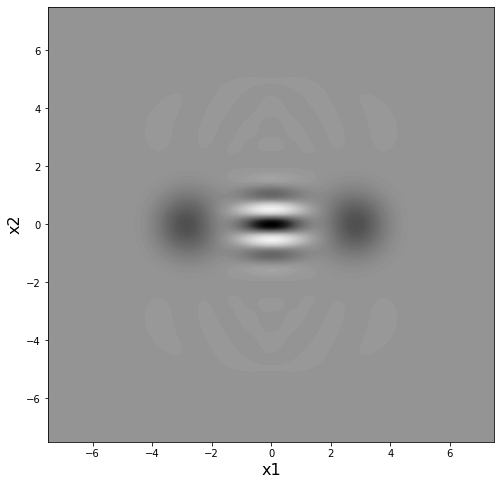

In [ ]:
ref.generate('grey',chi=0.75, v=5, p=4, speed=20)

1.0039639756514565
1.348


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

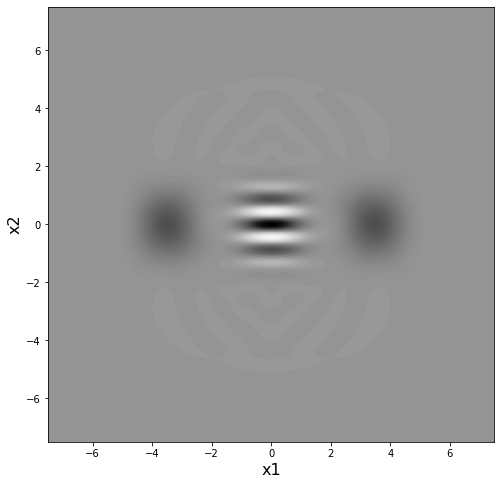

In [35]:
ref.generate('grey',chi=0.75, v=5, p=6, speed=20)

1.0096370843584301
1.96


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

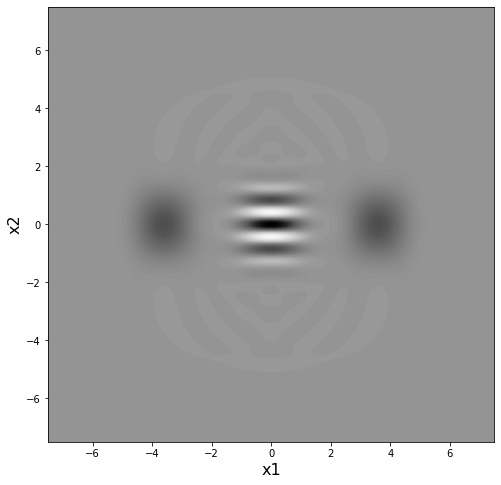

In [17]:
ref8.generate('grey',chi=0.75, v=5, p=6, speed=20)

0.991792271291233
1.96


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

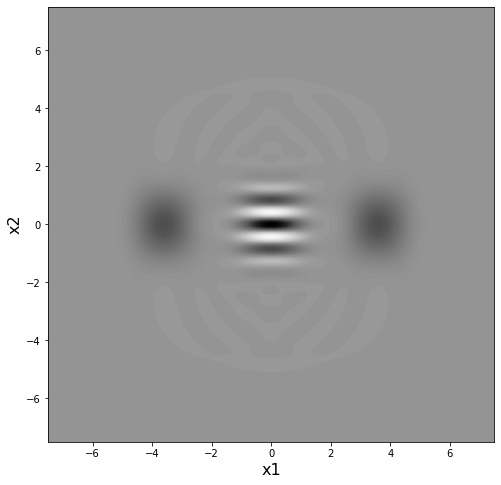

In [23]:
ref1.generate('grey',chi=0.75, v=5, p=6, speed=20)

In [17]:
ref_10=system(catsize=10, start=0, stop=2,num=2000)

In [75]:
ref0=system(catsize=2, start=0, stop=2,num=2000)

In [71]:
ref2=system(catsize=6, start=0, stop=2,num=2000)

In [73]:
ref3=system(catsize=8, start=0, stop=2,num=2000)

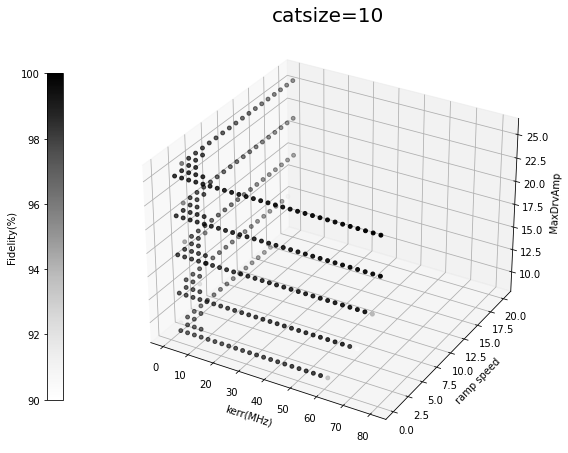

In [18]:
ref_10.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# 3h 

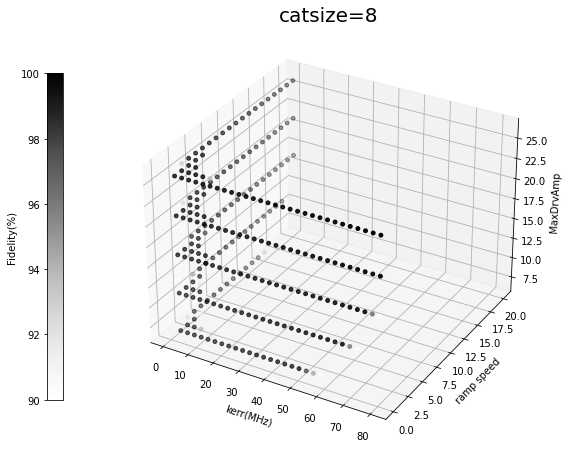

In [74]:
ref3.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# 3h 

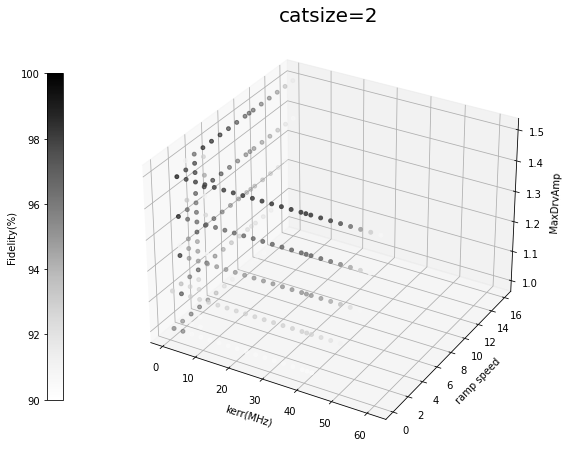

In [26]:
ref2.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

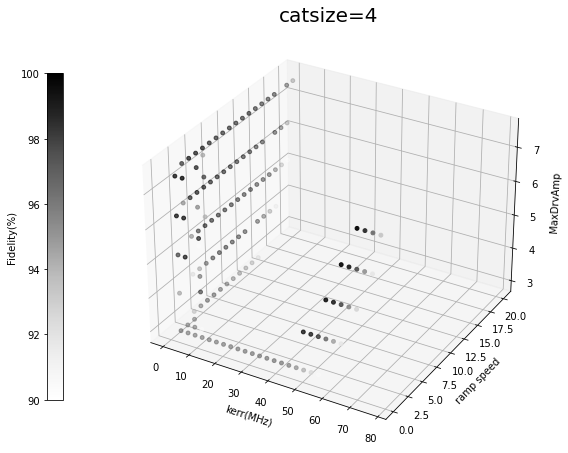

In [13]:
ref4.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

In [ ]:
ref6.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

In [ ]:
ref8.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

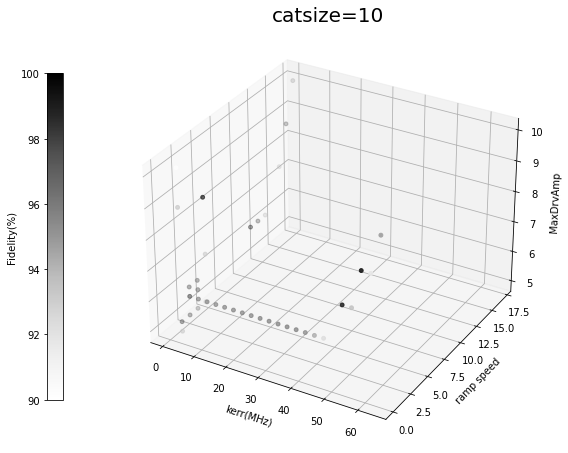

In [16]:
ref1.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected #amp

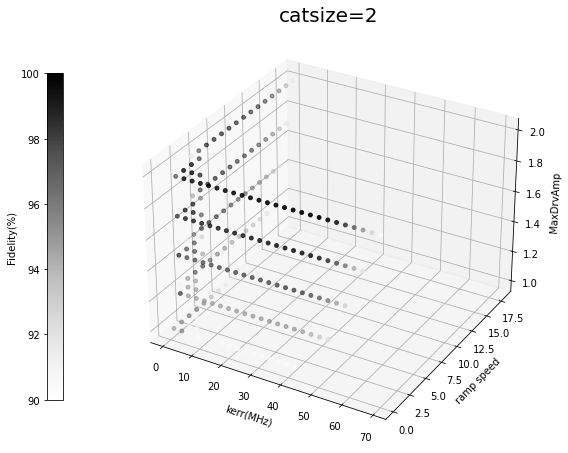

In [ ]:
ref0.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# 3h 

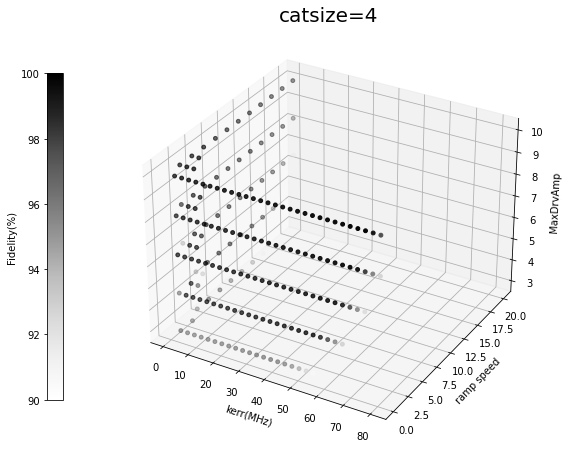

In [ ]:
ref.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=12)
# 3h 

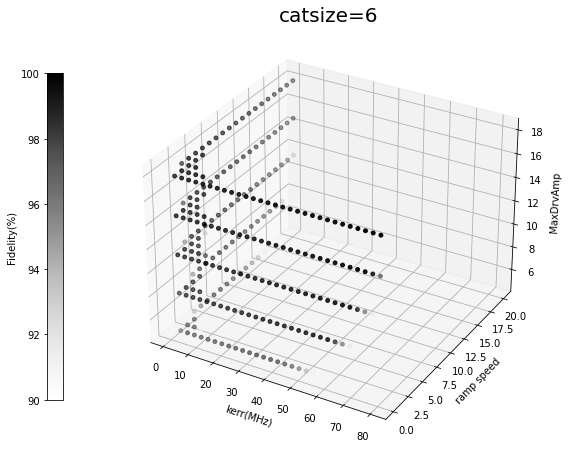

In [72]:
ref2.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# 3h 